# Proyecto Final Tecnologías Emergentes

### Integrantes
    Fabio Buitrago
    Luis Alejandro Bravo Ferreira
    Ana María Ortegón Sepúlveda

### Objetivo
El objetivo del proyecto es resolver un problema contextualizado en sistemas de información geográfica realizando una clasificación de imágenes satelitales. Para esto se debe hacer uso del conjunto de imágenes adjunta a este proyecto, explorando los datos, codificando el modelo deseado y generando un reporte con los resultados de la solución construida.

## Descripción del problema

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import time
import os
import shutil
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Exploración y Descripción del conjunto de datos

## Procedimiento

In [16]:
"""
    Divide las imágenes de una categoría en conjuntos de entrenamiento y prueba,
    y copia las imágenes correspondientes en los directorios respectivos.

    Args:
        category (str): El nombre de la categoría (subdirectorio) de las imágenes.
        source_dir (str): La ruta del directorio fuente que contiene las imágenes.
        train_dir (str): La ruta del directorio principal para las imágenes de entrenamiento.
        test_dir (str): La ruta del directorio principal para las imágenes de prueba.
        train_size (float, optional): Proporción de las imágenes que se utilizarán para el entrenamiento. 
                                      El resto se utilizará para la prueba. Por defecto es 0.8.
"""
def split_and_copy_images(category, source_dir, train_dir, test_dir, train_size=0.8):
    images = os.listdir(source_dir)
    train_images, test_images = train_test_split(images, train_size=train_size, random_state=42)
    
    category_train_dir = os.path.join(train_dir, category)
    category_test_dir = os.path.join(test_dir, category)
    
    os.makedirs(category_train_dir, exist_ok=True)
    os.makedirs(category_test_dir, exist_ok=True)
    
    for image in train_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(category_train_dir, image)
        shutil.copy(src_path, dst_path)
    
    for image in test_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(category_test_dir, image)
        shutil.copy(src_path, dst_path)

"""
    Prepara los generadores de datos de imágenes para entrenamiento y prueba.

    Args:
        cloudy_path (str): Ruta del directorio que contiene las imágenes de la categoría 'cloudy'.
        desert_path (str): Ruta del directorio que contiene las imágenes de la categoría 'desert'.
        green_path (str): Ruta del directorio que contiene las imágenes de la categoría 'green'.
        water_path (str): Ruta del directorio que contiene las imágenes de la categoría 'water'.
        base_dir (str, optional): Ruta base donde se crearán los directorios de entrenamiento y prueba. 
                                  Por defecto es './data/'.
        train_size (float, optional): Proporción de las imágenes que se utilizarán para el entrenamiento. 
                                      El resto se utilizará para la prueba. Por defecto es 0.8.
        new_img_width (int, optional): Ancho al que se redimensionarán las imágenes. Por defecto es 64.
        new_img_height (int, optional): Altura a la que se redimensionarán las imágenes. Por defecto es 64.
        batch_size (int, optional): Tamaño del lote para los generadores. Por defecto es 32.

    Returns:
        tuple: Generadores de datos de imágenes para entrenamiento y prueba.
"""
def prepare_data_generators(cloudy_path, desert_path, green_path, water_path, base_dir='./data/', train_size=0.8, new_img_width=64, new_img_height=64, batch_size=32):
    # Definir rutas para los datasets divididos
    train_dir = os.path.join(base_dir, 'training_set')
    test_dir = os.path.join(base_dir, 'test_set')

    # Crear directorios para entrenamiento y prueba
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Lista de categorías y sus rutas correspondientes
    categories = {
        'cloudy': cloudy_path,
        'desert': desert_path,
        'green': green_path,
        'water': water_path
    }

    # Dividir y copiar imágenes para cada categoría
    for category, path in categories.items():
        split_and_copy_images(category, path, train_dir, test_dir, train_size)

    # Crear generadores de datos de imágenes para entrenamiento y prueba
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Flujo desde el directorio y redimensionamiento de las imágenes a (64, 64)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(new_img_width, new_img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(new_img_width, new_img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, test_generator

# Dimensiones de las imágenes
new_img_width=64
new_img_height=64

# Tamaño del lote
batch_size = 32

# Definir rutas de los datasets originales
cloudy_path = "./data/cloudy"
desert_path = "data/desert"
green_path = "data/green_area"
water_path = "data/water"

# Uso de la función
train_generator, test_generator = prepare_data_generators(cloudy_path, desert_path, green_path, water_path, batch_size = batch_size)

Found 4504 images belonging to 4 classes.
Found 1127 images belonging to 4 classes.


In [17]:
"""
    Define y compila un modelo CNN para la clasificación de imágenes.

    Args:
        input_shape (tuple, optional): Forma de las imágenes de entrada. Por defecto es (64, 64, 3).
        num_classes (int, optional): Número de clases de salida. Por defecto es 4.
        learning_rate (float, optional): Tasa de aprendizaje para el optimizador. Por defecto es 0.00001.

    Returns:
        Model: Modelo compilado de Keras.
"""
def create_cnn_model(input_shape=(64, 64, 3), num_classes=4, learning_rate=0.00001):
    
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    custom_optimizer = Adam(learning_rate=learning_rate)

    # Compilar el modelo
    model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Mostrar el resumen del modelo
    model.summary()
    
    return model

# Uso de la función
model = create_cnn_model()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,837,572 (22.27 MB)

 Trainable params: 5,836,612 (22.26 MB)

 Non-trainable params: 960 (3.75 KB)

In [28]:
def create_cnn_model_v2(input_shape=(64, 64, 3), num_classes=4, learning_rate=0.00001):
    """
    Define y compila un segundo modelo CNN para la clasificación de imágenes.

    Args:
        input_shape (tuple, optional): Forma de las imágenes de entrada. Por defecto es (64, 64, 3).
        num_classes (int, optional): Número de clases de salida. Por defecto es 4.
        learning_rate (float, optional): Tasa de aprendizaje para el optimizador. Por defecto es 0.00001.

    Returns:
        Model: Modelo compilado de Keras.
    """
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(1024, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding="same")(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    custom_optimizer = Adam(learning_rate=learning_rate)

    # Compilar el modelo
    model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Mostrar el resumen del modelo
    model.summary()
    
    return model

# Uso de la función
model_v2 = create_cnn_model_v2()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,619,396 (86.29 MB)

 Trainable params: 22,617,412 (86.28 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [18]:
"""
    Entrena el modelo CNN con los generadores de datos de entrenamiento y prueba.

    Args:
        model (Model): Modelo de Keras a entrenar.
        train_generator (DirectoryIterator): Generador de datos de entrenamiento.
        test_generator (DirectoryIterator): Generador de datos de prueba.
        epochs (int, optional): Número de épocas para entrenar el modelo. Por defecto es 10.

    Returns:
        tuple: Historia del entrenamiento y tiempo total de entrenamiento en segundos.
"""
def train_cnn_model(model, train_generator, test_generator, epochs=10):

    start_time = time.time()
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator
    )
    
    end_time = time.time()
    total_time = end_time - start_time
    
    return history, total_time

# Uso de la función
history, training_time = train_cnn_model(model, train_generator, test_generator, epochs=10)

# Mostrar el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {training_time} segundos")


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 354ms/step - accuracy: 0.7335 - loss: 0.7938 - val_accuracy: 0.2662 - val_loss: 1.3842
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 330ms/step - accuracy: 0.9158 - loss: 0.2369 - val_accuracy: 0.2662 - val_loss: 1.4403
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - accuracy: 0.9414 - loss: 0.1584 - val_accuracy: 0.3940 - val_loss: 1.2944
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 310ms/step - accuracy: 0.9512 - loss: 0.1386 - val_accuracy: 0.7116 - val_loss: 0.8695
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 330ms/step - accuracy: 0.9528 - loss: 0.1268 - val_accuracy: 0.8518 - val_loss: 0.3005
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 322ms/step - accuracy: 0.9649 - loss: 0.0905 - val_accuracy: 0.9618 - val_loss: 0.1083
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 310ms/step - accuracy: 0.9609 - loss: 0.1000 - val_accuracy: 0.9778 - val_loss: 0.0741
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 323ms/step - accuracy: 0.9744 - loss: 0.0738 - val

In [29]:
# Uso de la función
history_v2, training_time_v2 = train_cnn_model(model_v2, train_generator, test_generator, epochs=10)

# Mostrar el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {training_time_v2} segundos")

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 90s 622ms/step - accuracy: 0.7770 - loss: 0.6657 - val_accuracy: 0.2662 - val_loss: 1.3842
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 86s 611ms/step - accuracy: 0.9445 - loss: 0.1572 - val_accuracy: 0.2662 - val_loss: 1.3753
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 615ms/step - accuracy: 0.9600 - loss: 0.1139 - val_accuracy: 0.2662 - val_loss: 1.3675
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 88s 620ms/step - accuracy: 0.9636 - loss: 0.1061 - val_accuracy: 0.5865 - val_loss: 1.1095
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 88s 621ms/step - accuracy: 0.9653 - loss: 0.0967 - val_accuracy: 0.9290 - val_loss: 0.2465
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.9699 - loss: 0.0913 - val_accuracy: 0.9769 - val_loss: 0.0705
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 595ms/step - accuracy: 0.9672 - loss: 0.0906 - val_accuracy: 0.9654 - val_loss: 0.0930
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 572ms/step - accuracy: 0.9687 - loss: 0

## Análisis de Resultados y Desempeño de la solución

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


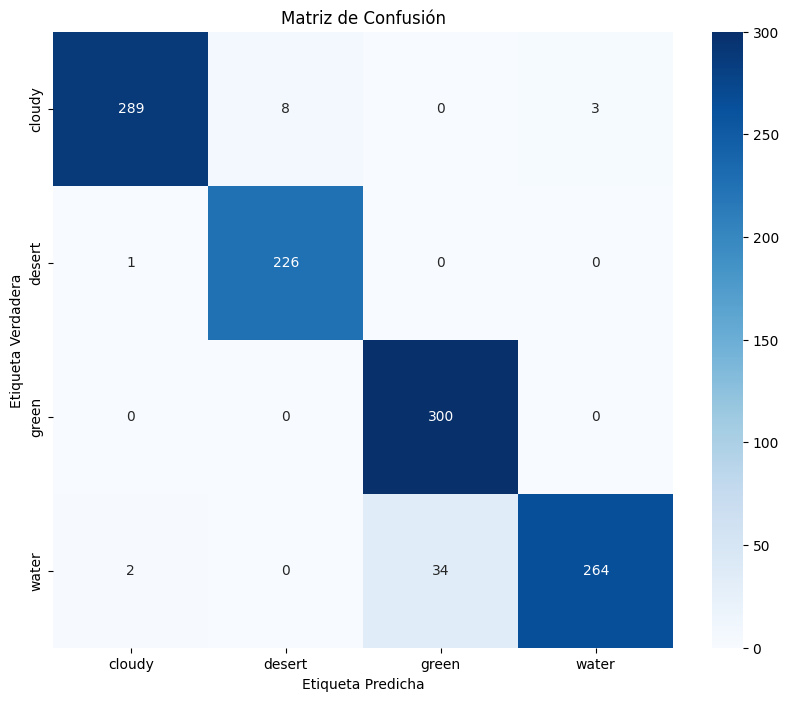

Informe de Clasificación
              precision    recall  f1-score   support

      cloudy       0.99      0.96      0.98       300
      desert       0.97      1.00      0.98       227
       green       0.90      1.00      0.95       300
       water       0.99      0.88      0.93       300

    accuracy                           0.96      1127
   macro avg       0.96      0.96      0.96      1127
weighted avg       0.96      0.96      0.96      1127

Precisión: 0.9574090505767524
Recall: 0.9574090505767524
F1 Score: 0.9571876543147998


In [20]:
"""
    Evalúa el modelo CNN utilizando el generador de datos de prueba, calcula varias métricas de rendimiento,
    y genera una matriz de confusión visualmente atractiva.

    Args:
        model (Model): Modelo de Keras entrenado.
        test_generator (DirectoryIterator): Generador de datos de prueba.
        train_generator (DirectoryIterator): Generador de datos de entrenamiento (usado para obtener índices de clase).

    Returns:
        dict: Diccionario que contiene la matriz de confusión, el informe de clasificación y métricas adicionales (precisión, recall, F1 score).
"""
def evaluate_and_plot_confusion_matrix(model, test_generator, train_generator):
    
    # Reiniciar el generador de prueba
    test_generator.reset()
    
    # Realizar predicciones sobre el conjunto de prueba
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    
    # Obtener las etiquetas predichas y verdaderas
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    
    # Obtener los índices de clase y nombres de clase
    class_indices = train_generator.class_indices
    class_names = list(class_indices.keys())
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Generar el heatmap de la matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()
    
    # Calcular el informe de clasificación
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print('Informe de Clasificación')
    print(class_report)
    
    # Calcular métricas adicionales
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    print(f'Precisión: {accuracy}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    
    # Retornar las métricas calculadas en un diccionario
    return {
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Uso de la función
evaluation_metrics = evaluate_and_plot_confusion_matrix(model, test_generator, train_generator)

# Acceso a las métricas
conf_matrix = evaluation_metrics['confusion_matrix']
class_report = evaluation_metrics['classification_report']
accuracy = evaluation_metrics['accuracy']
precision = evaluation_metrics['precision']
recall = evaluation_metrics['recall']
f1 = evaluation_metrics['f1_score']


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


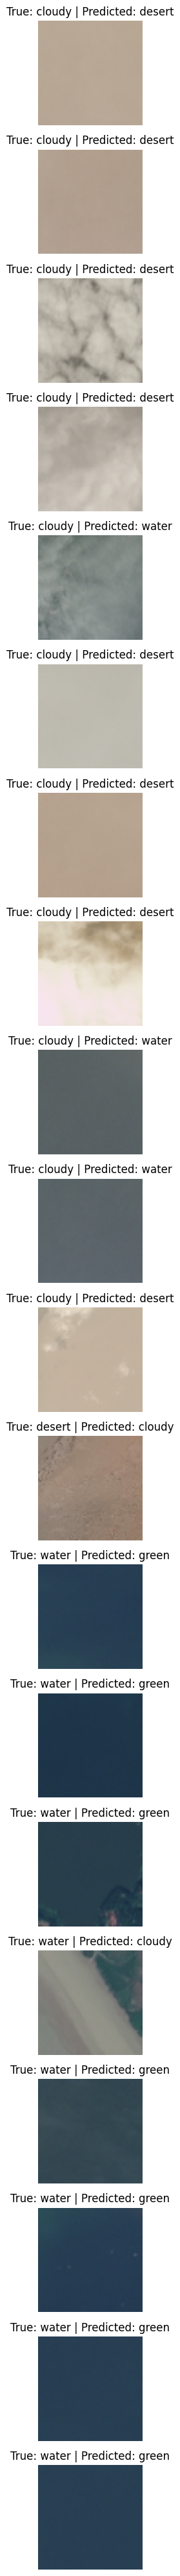

In [23]:
"""
    Muestra las imágenes mal clasificadas junto con sus etiquetas verdaderas y predichas.

    Args:
        model (Model): El modelo de Keras entrenado.
        test_generator (DirectoryIterator): Generador de datos de prueba.
        class_names (list): Lista de nombres de clases.
        num_images (int): Número de imágenes mal clasificadas a mostrar. Por defecto son 20.
"""
def display_misclassified_images(model, test_generator, class_names, num_images=20):

    # Reiniciar el generador de prueba
    test_generator.reset()
    
    # Realizar predicciones sobre el conjunto de prueba
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    
    # Obtener las etiquetas predichas y verdaderas
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    
    # Encontrar índices de imágenes mal clasificadas
    misclassified_indices = np.where(predicted_labels != true_labels)[0]
    
    # Mostrar algunas imágenes mal clasificadas
    num_display = min(num_images, len(misclassified_indices))
    plt.figure(figsize=(15, num_display * 2))
    
    for i, idx in enumerate(misclassified_indices[:num_display]):
        # Obtener ruta de la imagen
        img_path = test_generator.filepaths[idx]
        
        # Cargar la imagen
        img = load_img(img_path, target_size=(test_generator.target_size))
        img_array = img_to_array(img)
        
        # Mostrar la imagen
        plt.subplot(num_display, 1, i + 1)
        plt.imshow(img_array.astype("uint8"))
        plt.axis('off')
        
        # Etiquetas verdadera y predicha
        true_label = class_names[true_labels[idx]]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'True: {true_label} | Predicted: {predicted_label}')
    
    plt.tight_layout()
    plt.show()

# Uso de la función
class_names = list(train_generator.class_indices.keys())
display_misclassified_images(model, test_generator, class_names)


## Conclusiones